In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

# Load datasets

### Breast Cancer

In [8]:
dataset = load_breast_cancer()

In [9]:
df_x_bc = pd.DataFrame(dataset['data'], columns = dataset['feature_names']) #samples (539 vectors)

In [10]:
df_y_bc = dataset['target'] # labels (539 labels 1 == maniglent, 0 == benign)

### Phoneme

In [43]:
df_phoneme = pd.read_csv("./datasets/phoneme.dat/data", sep="\s+", header=None)

In [44]:
df_x_phoneme = df_phoneme.iloc[:,0:5]

In [45]:
df_y_phoneme = np.ravel(df_phoneme.iloc[:,5:6])

In [46]:
df_x_phoneme

,0,1,2,3,4
0,1.239670,0.874530,-0.205109,-0.078137,0.066867
1,0.268281,1.351780,1.035080,-0.331522,0.216897
2,1.566560,0.867437,1.299780,1.041250,0.559406
3,0.279295,0.989630,2.554790,-0.737988,0.000000
4,0.306809,1.272370,2.655580,-0.946160,-0.467142
5,0.960418,0.711808,-0.142762,0.090950,-0.060707
6,2.940710,0.656873,1.493180,-0.331060,-0.123295
7,0.400601,1.159040,2.064480,-0.689609,-0.308052
8,0.228973,1.747980,0.633643,0.259204,0.000000
9,0.302891,0.608544,0.474130,1.427180,-0.811085


# Initialize Parameters

In [37]:
n_estimators = 1000 # boosting iterations
max_depth = 2
n_flips = round(len(df_y_phoneme) * 0.02) # number of label filps for 5% noise
number_of_rounds = 10 # 100 for real experiment
ada_err_test = np.zeros((number_of_rounds,n_estimators))
ada_err_train = np.zeros((number_of_rounds,n_estimators))

In [38]:
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators) # init RandomForests

# Add noise

In [39]:
a = np.arange(len(df_y_phoneme))
np.random.shuffle(a)
for idx in a[:n_flips]: # apply noise
    df_y_phoneme[idx] = abs(df_y_phoneme[idx]-1)

# Run Classifiers

In [40]:
for r in range(number_of_rounds): # number of train/test split rounds. 
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        algorithm="SAMME.R") # init AdaBoost
    
    X_train, X_test, Y_train, Y_test = train_test_split(df_x_phoneme, df_y_phoneme, test_size=0.3) # split to train/test set (0.7, 0.3)
    
    ada.fit(X_train, Y_train) # train the classifier
    
    for i, y_pred in enumerate(ada.staged_predict(X_test)):
        ada_err_test[r][i] = zero_one_loss(y_pred, Y_test) # validate boosting rounds with test set

    
    for i, y_pred in enumerate(ada.staged_predict(X_train)):
        ada_err_train[r][i] = zero_one_loss(y_pred, Y_train) # validate boosting rounds with train set


# Plot validation

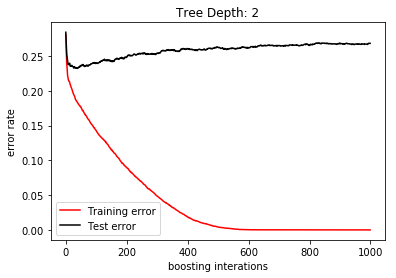

In [41]:
fig = plt.figure()
plt.plot(ada_err_train.mean(axis=0), label="Training error", color="red")
plt.plot(ada_err_test.mean(axis=0), label="Test error", color="black")
plt.ylabel("error rate")
plt.xlabel("boosting interations")
plt.title(f"Tree Depth: {max_depth}")
plt.legend()
plt.show()
#fig.savefig('temp.png', dpi=fig.dpi)